## **BMEN 4470 - Deep Learning for Biomedical Signal Processing Assignment 3: Classification of Protein Sequences via LSTMs and TCNs with Skip Connections**

Due 11:59pm on November 7th

Proteins are large, complex bio-molecules responsible for carrying out multiple critical bodily functions.  They are composed of chains (long variable-order sequences with repeats) of 20 possible amino acids.  The constituent amino acids that make up a protein determine its unique structure as well as function.  In this assignment, we will use deep learning and a protein database called 'Pfam' to classify amino acid sequences into their protein families. 

In [ ]:
#1. First download the dataset from here: https://www.kaggle.com/googleai/pfam-seed-random-split
#2. Upload the data folder from #1 to your Google Drive
#MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [ ]:
#Required Imports
%matplotlib inline
!pip install einops
!pip install Levenshtein

import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools
import random
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from Levenshtein import distance as levenshtein_distance

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


     |████████████████████████████████| 110 kB 4.0 MB/s 
     |████████████████████████████████| 1.6 MB 24.2 MB/s 


In [ ]:
# Reading in the Pfam dataset
# data is randomly split into three folders [train(80%), test(10%), dev(10%)]
# reading and concatenating data for each folder.

data_path = '/gdrive/MyDrive/BMEN4470/HW3/Dataset/random_split' #Make sure to modify to your location
print('Available data', os.listdir(data_path))

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

# reading all data_partitions and visualizing (head) of the data
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')
df_train.head()

Available data ['dev', 'random_split', 'test', 'train']


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


# Overview of Data Components:

*sequence:* This is the input to the model, an amino acid sequence for a protein. There are 20 common amino acids (frequency > 1,000,000), and 4 amino acids that are uncommon: U, B, O, Z, and X stands for an unknown or generic/'wild-card' amino acid.

*family_accession:* These are the labels (outputs) of the model. Accession number is in the form PFxxxxx.y, where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

*sequence_name:* Sequence name, in the form "uniprot_accession_id/start_index-end_index".

*aligned_sequence:* The aligned version of the *sequence* (above) with gaps retained.

*family_id:* One word name for protein family.


**Getting Familiar with the Data:** the following few cells will help you get familiar with the data, an important step to allow you to build your deep learning sequence model

In [ ]:
# An example unaligned sequence, input to the model
# Each character represents one of the 25 (20 common + 4 uncommon + 1 'wild-card') 
# amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [ ]:
# Given data size (number of sequences in each set)
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [ ]:
#Getting a sense of the data: number of families/classes
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

# Unique classes in the given dataset : [df_train, df_val and df_test]
calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


**Problem 1a:** Use the code in the following cell to plot the typical lengths of sequences in this dataset.  What is the the approximate most prevalent/common sequence length?  You will use this later for pre-processing your sequences.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

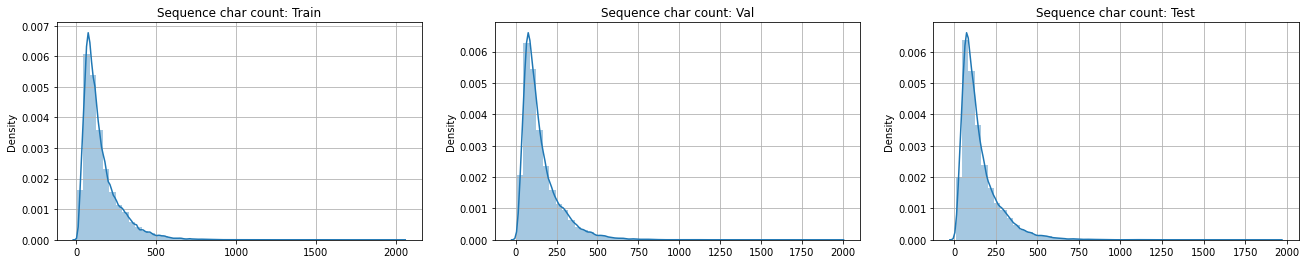

In [ ]:
# The code below will allow you to plot the typical lengths of
# amino acid sequences for train, val, and test datasets.  

df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)


plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


Amino acids are represented in a protein sequence with their corresponding 1 letter code; for example, the code for alanine is (A), arginine is (R), and so on. The complete list of amino acid codes is [here](https://www.ddbj.nig.ac.jp/ddbj/code-e.html) under 'Amino Acid Codes'.

In [ ]:
#Determine the number of instances of each amino acid code across all sequences
#in train, val, and test sets 
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]
  
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


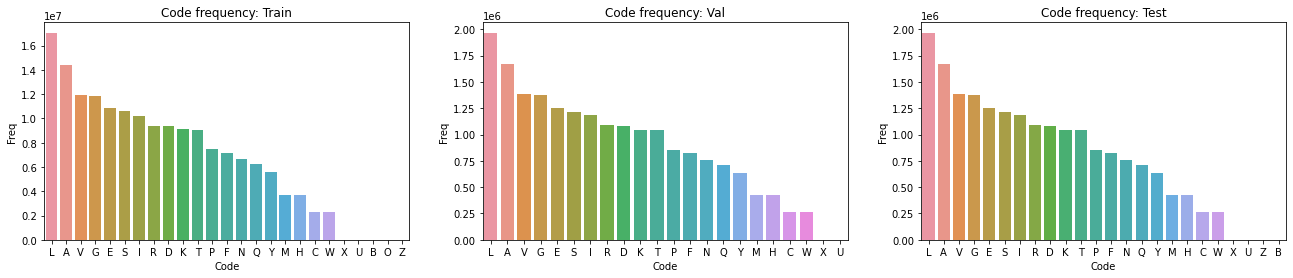

In [ ]:
#Plot the Amino Acid Code frequency for this dataset
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [ ]:
# Since our dataset is large, we will consider only the top 300 most-observed
# protein classes/families due to limited computational power.

classes = df_train['family_accession'].value_counts()[:300].index.tolist()
len(classes)

# Filtering data based on considered 300 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 300 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Data size after considering 300 classes for each data split:
Train size : 210358
Val size : 26129
Test size : 26129
Number of unique classes in Train:  300
Number of unique classes in Val:  300
Number of unique classes in Test:  300


Here we start developing our **Deep Learning** model.  First task is to preprocess the amino acid sequences in our dataset.

In [ ]:
# The code below creates our amino acid code sequence dictionary
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
#Now we will encode our sequences made of letters into sequences of integers
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids (and X 'wild-card') are taken into consideration.
    Remaining 4 uncommon amino acids are categorized as 0 (so not included).
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list
  
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

#Just to visualize an example of the output
print(train_encode[0])

[16  4  8  9 10 10  7  1 14 18 12 13  7  5 10  5 12  1 10 12 17 10 16  1
 18  8 15 15  3 13  4  9  1  2  7 10 18 10 12 10 16 17  5  5 15  9 12 10
  9 15 13 16  4  4  1  1 10 16  4  4 18  1  7 18  1  1 20 10  4  8  4 14
  1 15  5 10  3  9 10]


In [ ]:
# The code to encode labels/output variable y (amino acid family/class) into integers
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((210358,), (26129,), (26129,))

**Problem 1b:** Now we must ensure all sequences are the same length since our sequence model can only take in fixed-size inputs.  Pad the sequences using Keras *pad_sequences* [function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences), using the max_length you determined in part (a).  Use 'post' padding to pad with 0 if the total sequence length is less than max_length or truncate the sequence (if longer) to max_length.

In [ ]:
# Your code below for padding sequences


#############################################

# Determining the max_length

# Calculating the average sequence length
sum_of_train = 0
for item in df_train['sequence']:
  sum_of_train += len(item)

avg_seq_length = sum_of_train / len(df_train['sequence'])

# After we get the average we can add an arbitrary small positive constant
# because we want to get more data to work with and we can see by the graph
# from 1a) that most of the data is concentrated in the same place

max_length_from_a = avg_seq_length + 15

from math import floor as Fl
max_length_from_a = int(Fl(max_length_from_a))

print(max_length_from_a) # The value we get is 170, which seems acceptable after looking at the graph

#############################################

max_length = max_length_from_a # Fill this in from part 1a

# Creating a function to simpify the padding process

def adding_padding_to_the_data(seq):
  return pad_sequences(
    seq,
    maxlen=max_length, 
    dtype='int32',
    padding='post',
    truncating='post',
    value=0
)

padded_data_train = adding_padding_to_the_data(train_encode)
padded_data_val = adding_padding_to_the_data(val_encode)
padded_data_test = adding_padding_to_the_data(test_encode)

padded_data = {
    'padded_data_train': padded_data_train,
    'padded_data_val': padded_data_val,
    'padded_data_test': padded_data_test
}

# printing the shapes of the new data
for key, value in padded_data.items():
  print(f'{key} -> {value.shape}')


170
padded_data_train -> (210358, 170)
padded_data_val -> (26129, 170)
padded_data_test -> (26129, 170)


**Problem 1c:** Now encode input sequences and output labels using one-hot encoding (zeros everywhere except for at location of the appropriate amino acid code) using Keras *to_categorical* function.

In [ ]:
# Your code here: One hot encoding of sequences

# one hot encode
encoded_inputs = {
    'train': 0,
    'test': 0,
    'val': 0
}

encoded_inputs['train'] = to_categorical(
    padded_data['padded_data_train']
)

encoded_inputs['test'] = to_categorical(
    padded_data['padded_data_test']
)

encoded_inputs['val'] = to_categorical(
    padded_data['padded_data_val']
)

# Show the new data shape
for key, value in encoded_inputs.items():
  print(f'{key} -> {value.shape}')

# Show the actual inputs
print(encoded_inputs)


# invert encoding to show that the encoding actually works
from numpy import argmax
inverted = argmax(encoded_inputs['train'][0])
print(inverted)

# as we see from the print function, the first value corresponds to 16,
# which is the actual value, so our code works

train -> (210358, 170, 21)
test -> (26129, 170, 21)
val -> (26129, 170, 21)
{'train': array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ...

In [ ]:
# Your code here: One hot encoding of outputs

encoded_outputs = {
    'train': 0,
    'test': 0,
    'val': 0
}

encoded_outputs['train'] = to_categorical(
    y_train_le
)

encoded_outputs['test'] = to_categorical(
    y_test_le
)

encoded_outputs['val'] = to_categorical(
    y_val_le
)

# Show the new data shape
for key, value in encoded_outputs.items():
  print(f'{key} -> {value.shape}')

# Show the actual inputs
print(encoded_outputs)



train -> (210358, 300)
test -> (26129, 300)
val -> (26129, 300)
{'train': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'test': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'val': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}


In [ ]:
#Utility functions: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

**Problem 1d:** Implement code here for a [bidirectional LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) using Keras Functional or Sequential API.  Unlike RNNs which only take input from the previous timestep, LSTMs can remember information from the distant past via gating mechanisms.  Bidirectional LSTMs can incorporate contextual information from both past and future, improving their performance even more compared to unidirectional LSTMs on sequential data.

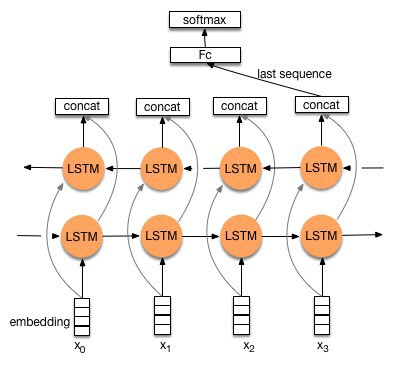

In [ ]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

# Initializing constants
input_data_length = encoded_inputs['train'].shape[-1]
output_data_length = encoded_outputs['train'].shape[-1]
embedding_layer_neurons = 2**7
bidirectional_LSTM_layer_1 = 2**6
bidirectional_LSTM_layer_2 = 2**7
l2_regularization_penalty = 0.0001
dropout_val = 0.2

# Creating a Sequential Keras model
from tensorflow.keras.models import Sequential
model = Sequential()

model.add(
    Input(shape=(max_length, ))
)

# Adding an Embedding layer
model.add(
    Embedding(input_data_length,
              embedding_layer_neurons,
              input_length=max_length)
    )

# Adding 2 Bidirectional layers

model.add(
    Bidirectional(
        LSTM(bidirectional_LSTM_layer_1,
             return_sequences=True, 
             kernel_regularizer=l2(l2_regularization_penalty), 
             recurrent_regularizer=l2(l2_regularization_penalty), 
             bias_regularizer=l2(l2_regularization_penalty), 
             activity_regularizer=l2(l2_regularization_penalty)
             )
        )
    )

model.add(
    Bidirectional(
        LSTM(bidirectional_LSTM_layer_2,
             return_sequences=False)
        )
    )

# Applying a dropout for better training of the NN

model.add(
    Dropout(dropout_val)
)

# Adding a final Dense layer with regularization and a softmax function
model.add(
    Dense(output_data_length,
          activation='softmax'
          )
    )


# Compiling the model and printing its summary
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 170, 128)          2688      
                                                                 
 bidirectional (Bidirectiona  (None, 170, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 300)               77100     
                                                                 
Total params: 441,772
Trainable params: 441,772
Non-trai

**Problem 1e:** Now train your model using Keras model.fit function. Add the given early stopping as a parameter to your fit function to prevent overtraining.  Use at least 10 epochs (it will take 15-20min to train with GPU: Remember turn GPU on by going to Runtime --> Change Runtime Type --> GPU) and a batch size of 256.  Validate on your padded validation sequences from above.

In [ ]:
# Train your model using Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Defining the number of epochs of the model
epochs_num = 2**4

history1 = model.fit(padded_data['padded_data_train'],
                     encoded_outputs['train'],
                     epochs=epochs_num,
                     validation_data=(
                         padded_data['padded_data_val'],
                         encoded_outputs['val']
                     ),
                     callbacks=[es],
                     batch_size=256) #Your code here


Epoch 1/16
822/822 [==============================] - 69s 74ms/step - loss: 2.2236 - accuracy: 0.5006 - val_loss: 0.8175 - val_accuracy: 0.8145
Epoch 2/16
822/822 [==============================] - 59s 72ms/step - loss: 0.6152 - accuracy: 0.8625 - val_loss: 0.3915 - val_accuracy: 0.9189
Epoch 3/16
822/822 [==============================] - 59s 72ms/step - loss: 0.3341 - accuracy: 0.9310 - val_loss: 0.3409 - val_accuracy: 0.9249
Epoch 4/16
822/822 [==============================] - 59s 72ms/step - loss: 0.2275 - accuracy: 0.9555 - val_loss: 0.2007 - val_accuracy: 0.9615
Epoch 5/16
822/822 [==============================] - 59s 72ms/step - loss: 0.1675 - accuracy: 0.9686 - val_loss: 0.1473 - val_accuracy: 0.9733
Epoch 6/16
822/822 [==============================] - 59s 72ms/step - loss: 0.1323 - accuracy: 0.9765 - val_loss: 0.1118 - val_accuracy: 0.9804
Epoch 7/16
822/822 [==============================] - 59s 72ms/step - loss: 0.1092 - accuracy: 0.9807 - val_loss: 0.1002 - val_accuracy:

822/822 [==============================] - 24s 29ms/step - loss: 0.0286 - accuracy: 0.9965
Train loss:  0.028571654111146927
Train accuracy:  0.9965440034866333
----------------------------------------------------------------------
103/103 [==============================] - 3s 29ms/step - loss: 0.0522 - accuracy: 0.9891
Val loss:  0.0521879680454731
Val accuracy:  0.9891308546066284
----------------------------------------------------------------------
103/103 [==============================] - 3s 29ms/step - loss: 0.0513 - accuracy: 0.9895
Test loss:  0.05133240297436714
Test accuracy:  0.9894753098487854


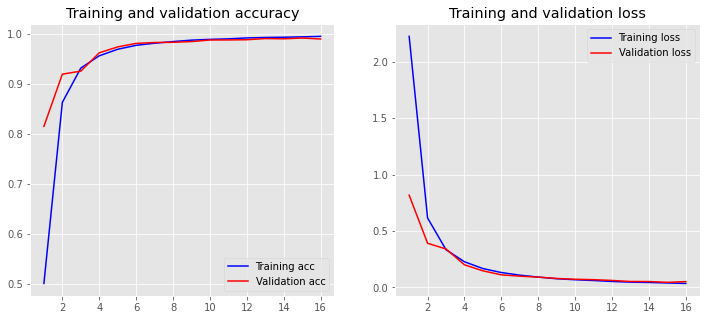

In [ ]:
# Show your model results and plots
display_model_score(model,
                    [padded_data['padded_data_train'], encoded_outputs['train']],
                    [padded_data['padded_data_val'], encoded_outputs['val']],
                    [padded_data['padded_data_test'], encoded_outputs['test']],
                    256)

plot_history(history1)

In [ ]:
#Save your model in case you need to run again to save time with training
model.save_weights('/gdrive/MyDrive/BMEN4470/HW3/bidirectional_LSTM_model.h5')

**Problem #2a**: In this problem, we will assess the interclass variability of embeddings. We will plot t-SNE clusters within and between family_accession samples.  

Extract the weights from the embedding layer of your model1. The shape of your weight matrix should make sense - it should be (sequence_length x embedding_dim)

In [ ]:
# Get the needed layer, to extract its weights
embedding_layer = model.get_layer('embedding')

# Extracting the weights
embedding_weights = embedding_layer.get_weights() # Your code here to save your model weights
embedding_weights_ndarray = np.array(embedding_weights)
embedding_weights_ndarray_squeeze = embedding_weights_ndarray.squeeze()

print(embedding_weights_ndarray_squeeze.shape)

(21, 128)


Within 5 classes, compute the embeddings for each sample in your validation set, storing them as you go to a new data matrix (X). 

In [ ]:
from einops import rearrange
num_classes = 5 # number of classes we will store average distances for

X = None
y = None
for class_of_interest in classes[:num_classes]:
  # e.g. class_of_interest == 'PF01967.21'
  class_indices = list(val_sm.loc[val_sm.family_accession==class_of_interest].index)
  
  all_class_samples = np.dot(encoded_inputs['val'][class_indices],
                             embedding_weights_ndarray_squeeze) # Your code here for storing the forward pass from the val_ohe samples that match your class_of_interest. 

  # this rearranges to samples x features shape by flattening time and embedding shapes
  all_class_samples = rearrange(all_class_samples,'s t e -> s (t e)') 
  if X is None:
    X = all_class_samples
    y = np.array([class_of_interest] * len(class_indices))
  else:
    X = np.concatenate((X, all_class_samples))
    y = np.concatenate((y, np.array([class_of_interest] * len(class_indices)))) 

print(X.shape) # Check the shape to make sure it's right

(1295, 21760)


**Problem #2b**: Use t-SNE to fit and transform your X matrix to 2 components for visualization. 

*Answer the following questions from your plot*:

What do you notice about the clusters? Why does this result occur and how does it help the LSTM model better learn to classify protein function? 

In [ ]:
from sklearn.manifold import TSNE
# Your t-SNE code here

model_tsne = TSNE(n_components=2, 
                  random_state=0)
tsne_results = model_tsne.fit_transform(X)

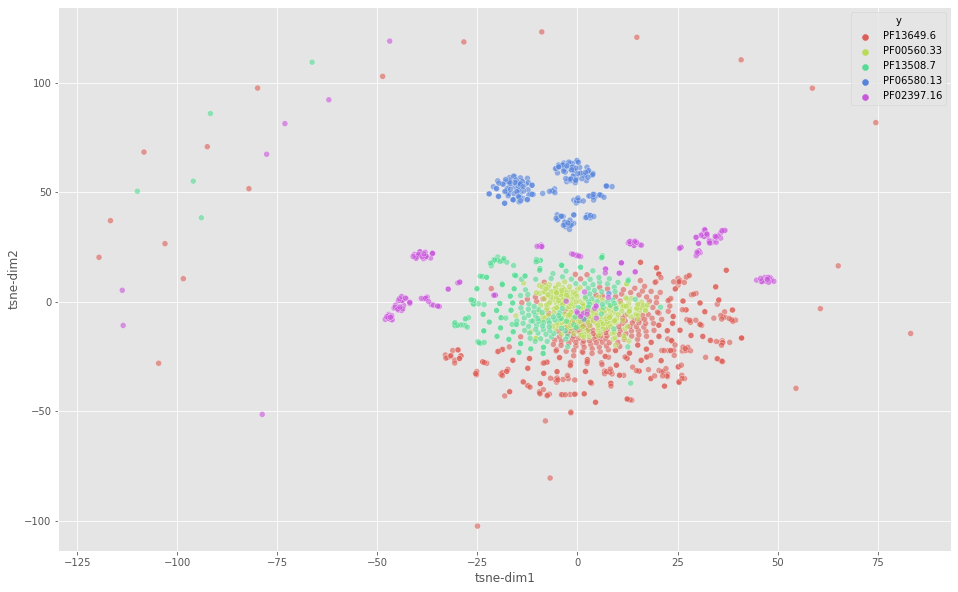

In [ ]:
import seaborn as sns

# this should plot your lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = y
tsne_df['tsne-dim1'] = tsne_results[:,0]
tsne_df['tsne-dim2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", num_classes),
    data=tsne_df,
    legend="full",
    alpha=0.6
)

Your answer to the questions here.

We see a general trend that each different protein class cluster is located on a separate space throughout the graph. The PF02397.16 and PF06580.13 are clearly differentiable from all other protein clusters. The others can be divided into a 'central' i.e. PF00560.33 protein, a 'surrounding' i.e. PF13508.7 and 'down' i.e. PF13649.6 protein. We can account for the amino acids that are overlapping by acknoledging that we used 170 as our max_legth, which would naturally create a bit more bias. However, the result would suggest that the amino acids from the different classes are similar to each other and, therefore, can be distinguished using their unique class-based features. Since we created embeddings that help us project higher-dimensional vectors (which are basically the representation of amino acids in the Computer memory) onto the map above, we can use the vector space, given by the projections, to train our neural networks effectively.

We can see by the 2D map above that the embedding actually managed to reduce the vector components to just 2 and at the same time this is enough for us to clearly distunguish spaces with more than 98% population of amino acids of the same class. This means that by using LSTMs we can benefit from the fact that we can train the network more efficiently and for larger datasets.

Clear variables in case we run into RAM issues with Colab updates

In [ ]:
import gc

try:
  del tsne_results
  del tsne_df
  del embeddings
  del model1
  del df_train
  del df_val
  del df_test
  del train_encode
  del val_encode
  del test_encode
  del y_train_le
  del y_val_le
  del y_test_le
  del train_pad
  del val_pad
  del test_pad
  gc.collect()
except:
  pass

**Problem #3a:** Now we will repeat the protein sequence classification task of Problem #1  using a ResNet based [temporal (1D) convolution network](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) with dilation.  Use Keras functional API to design two convolutional blocks and then use the Add() [function](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) to combine your input (data) with the output of your 2nd convolutional block.

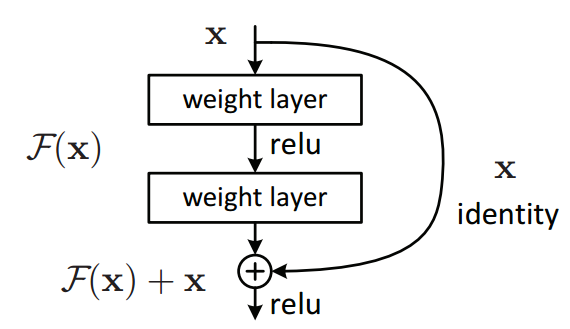

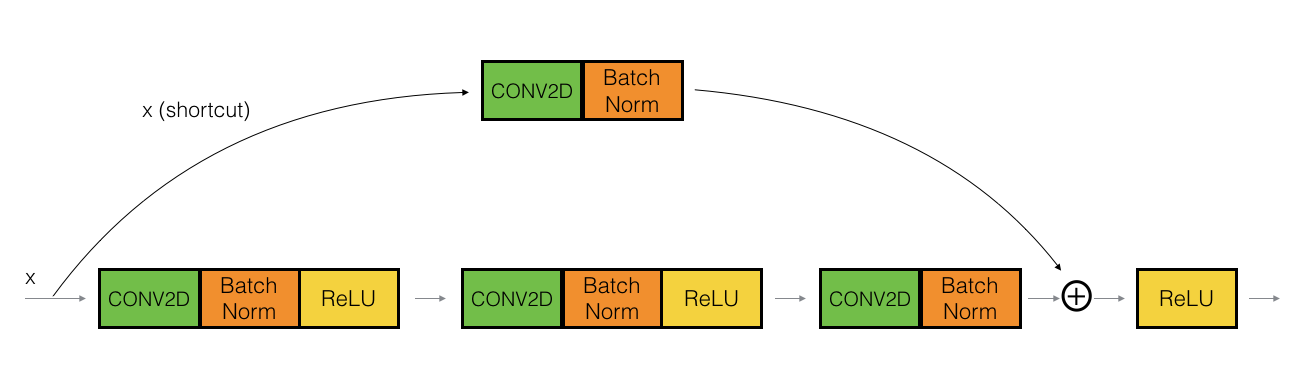

This is the model* that I implemented

Note*: With Conv2D -> Conv1D

In [ ]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate):
    """
    _data: input
    _filters: convolution filters
    _d_rate: dilation rate
    """
    # Add your layers here

    # For the residual block I tried Implementinf the model above,
    # but changing the Conv2D to Conv1D for the purpose of our task

    # We define a constant for the number of skipped blocks in the middle
    skipped_blocks = 2
    
    # Save the input value. We'll need this at the last step for the 'Add' function
    x_initial = data
    
    # First component of main path
    # i.e. before the 'skipped' part
    x = Conv1D(filters=filters,
               kernel_size=1,
               dilation_rate=d_rate,
               padding='same',
               kernel_regularizer=l2(l2_regularization_penalty))(data)
    x = BatchNormalization()(data)
    x = Activation('relu')(x)
    
    # Second component of main path 
    # i.e. after the 'skipped' part
    x = Conv1D(filters=filters, 
               kernel_size=1+skipped_blocks, 
               padding='same', 
               kernel_regularizer=l2(l2_regularization_penalty))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    # Adding initial x value to the initial x, and passing it through 
    x = Add()([x, x_initial])
    x = Activation('relu')(x)
    
    return x

**Problem 3b:** Design a simple 1D temporal convolution network around the residual networks (called below using the definition you implemented in part a) with Keras Functional API.  Include an input layer and convolution layer before the residual networks and max pooling, dropout, flatten, and output dense layers after them.  You can refer to this [paper](https://www.biorxiv.org/content/10.1101/626507v4.full) which describes the final architecture in more detail.

In [ ]:
#Insert your code before and after the residual networks called below

#input
input_layer = Input(shape=(max_length,
                           input_data_length))

#initial conv
convolution_layer = Conv1D(64, 
                           1, 
                           padding='same')(input_layer)

# per-residue representation
# I changed 128 to 64, because otherwise Google Colab quickly runs out of RAM
residual_layer_1 = residual_block(convolution_layer, 64, 2) 
residual_Layer_2 = residual_block(residual_layer_1, 64, 3)

#Max Pooling & Dropout
x = MaxPooling1D(3)(residual_Layer_2)
x = Dropout(dropout_val)(x)

#softmax classifier & flatten layer
x = Flatten()(x)
output_layer = Dense(output_data_length,
                     activation='softmax', 
                     kernel_regularizer=l2(l2_regularization_penalty))(x)

#Compile your model
TCN_1D_model = Model(inputs=input_layer,
                     outputs=output_layer)
TCN_1D_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

print(TCN_1D_model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 170, 21)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 170, 64)      1408        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 170, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 170, 64)      0           ['batch_normalization[0][0]']

**Problem 3c:** Train your model with early stopping using 10 epochs and a batch size of 256.  Validate with your one-hot-encoded validation data from above.

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history2 = TCN_1D_model.fit(encoded_inputs['train'],
                            encoded_outputs['train'],
                            epochs=16,
                            validation_data=(
                            encoded_inputs['val'],
                            encoded_outputs['val']
                            ),
                            callbacks=[es],
                            batch_size=256) #your code here

Epoch 1/16
822/822 [==============================] - 29s 15ms/step - loss: 0.6197 - accuracy: 0.9006 - val_loss: 0.1262 - val_accuracy: 0.9884
Epoch 2/16
822/822 [==============================] - 11s 14ms/step - loss: 0.1033 - accuracy: 0.9923 - val_loss: 0.1152 - val_accuracy: 0.9894
Epoch 3/16
822/822 [==============================] - 12s 14ms/step - loss: 0.0834 - accuracy: 0.9955 - val_loss: 0.1078 - val_accuracy: 0.9908
Epoch 4/16
822/822 [==============================] - 12s 14ms/step - loss: 0.0772 - accuracy: 0.9961 - val_loss: 0.1101 - val_accuracy: 0.9892
Epoch 5/16
822/822 [==============================] - 12s 14ms/step - loss: 0.0768 - accuracy: 0.9959 - val_loss: 0.1045 - val_accuracy: 0.9908
Epoch 6/16
822/822 [==============================] - 12s 14ms/step - loss: 0.0746 - accuracy: 0.9968 - val_loss: 0.1018 - val_accuracy: 0.9922
Epoch 7/16
822/822 [==============================] - 12s 14ms/step - loss: 0.0766 - accuracy: 0.9963 - val_loss: 0.1024 - val_accuracy:

In [ ]:
# Save the model & its history for reusability
TCN_1D_model.save_weights('/gdrive/MyDrive/BMEN4470/HW3')
np.save('/gdrive/MyDrive/BMEN4470/HW3/history2.npy',
        history2.history)

822/822 [==============================] - 5s 6ms/step - loss: 0.0546 - accuracy: 0.9995
Train loss:  0.054564468562603
Train accuracy:  0.9994865655899048
----------------------------------------------------------------------
103/103 [==============================] - 1s 6ms/step - loss: 0.0759 - accuracy: 0.9949
Val loss:  0.07586340606212616
Val accuracy:  0.9948716163635254
----------------------------------------------------------------------
103/103 [==============================] - 1s 6ms/step - loss: 0.0715 - accuracy: 0.9956
Test loss:  0.0714830532670021
Test accuracy:  0.9955987334251404


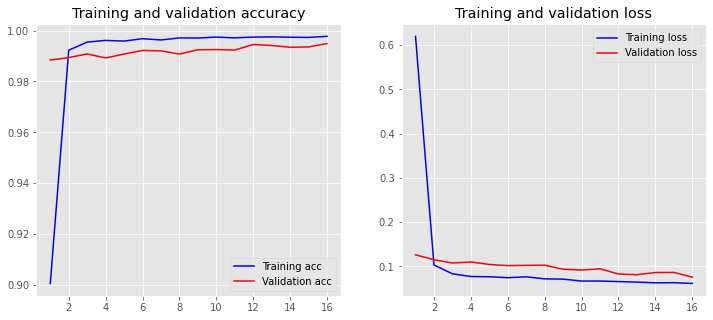

In [ ]:
#Plot loss and accuracy and evaluate your model.

plot_history(history2)
display_model_score(TCN_1D_model,
                    [encoded_inputs['train'], encoded_outputs['train']],
                    [encoded_inputs['val'], encoded_outputs['val']],
                    [encoded_inputs['test'], encoded_outputs['test']],
                    256)

**Problem 3d:** Provide a brief comparison of your two models in a markdown cell.  What were their train, val, and test accuracies?  Which one performed better?  Why do you think this is the case?

Write your answer here...

Generally, we can see that the ResNet model is better in terms of all metrics. If we compare the epoch history of both models, we can recognize that the ResNet achieves not only higher results in terms of accuracy (in all metrics -> train, test, val), but also it does this in a very time-efficient manner. The Bidirectional LSTM model is somewhat better in terms of the number of trainable parameters that it uses. The ResNet uses approximately 2.5 times more trainable parameters and overall more than 1 million parameters. This can easily get very computationally heavy as input data becomes larger. Another advantage of the ResNet model is the training time. Although the ResNet model has larger number of trainable parameters, it trains much faster for the same number of epochs and by training it multiple times, I managed to see that on average, Early Stopping occurs at 7th or 8th epoch, meaning that the model achieves its maximum accuracy almost immediately. In comparison, the bidirectional LSTM triggers Early Stopping on average on the 14th epoch. If we look at the plotted data from the history, we can conclude that both models behave pretty much the same way - they both form a 'logarithmic-like' graph which asymptotically goes to 1.

In conclusion, the ResNet model performs better. This would imply that by skipping connections, we actually helped the model be more precise by forcing it to remember important spatial data from the previous layers.

The train, val and test accuracies are as follows:


---
ResNet:
1. Train: 99.9%
2. Test: 99.6%
3. Val: 99.5%
---
Bidirectional LSTM:
1. Train: 99.7%
2. Test: 98.9%
3. Val: 98.9%
---


P.S. I submitted the homework very late and I am extremely sorry for this. I've just had 4 midterms last week and Google Colab kept crashing because of resource usage so I had to rerun blocks of code (many times the whole program) 20+ times. Once again, I am sorry for submitting 4 days late and I hope that the 'late submit penalty' would not be crushing.

**What to Submit:** Submit this ipynb with your code and short written responses in markdown cells by **November 7th at 11:59pm**.